In [1]:
#import liabraries
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data


In [2]:
#import zip file
import zipfile

zip_path = "X-ray_dataset.zip"  # make sure filename matches exactly
extract_to = "images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction completed!")


Extraction completed!


Opening image: images\chest_xray\test\NORMAL\IM-0001-0001.jpeg


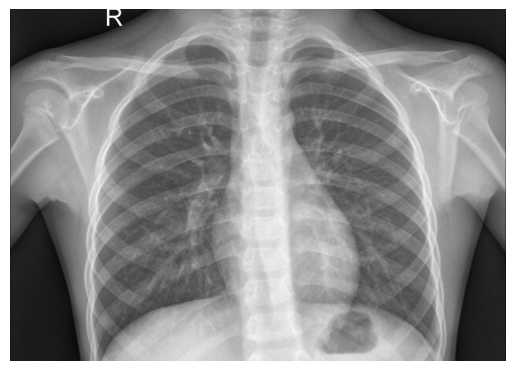

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

folder = "images"

# valid image extensions
valid_ext = (".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".gif")

img_path = None

# Walk through all subfolders to find first image
for root, dirs, files in os.walk(folder):
    for f in files:
        if f.lower().endswith(valid_ext):
            img_path = os.path.join(root, f)
            break
    if img_path:
        break

if img_path:
    print("Opening image:", img_path)
    img = Image.open(img_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
else:
    print("No image files found!")


In [4]:
#import librariesS
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential


In [5]:
#Set Paths
base_dir = "images/chest_xray"

train_dir = base_dir + "/train"
test_dir = base_dir + "/test"
val_dir = base_dir + "/val"


In [6]:
#Data Preprocessing + Augmentations
IMAGE_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode="binary"
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode="binary"
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode="binary",
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
#Build Model (Transfer Learning)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False   # freeze pretrained layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # binary classifier
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
#Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 477s 3s/step - accuracy: 0.9026 - loss: 0.2328 - val_accuracy: 0.5625 - val_loss: 0.7630
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.9358 - loss: 0.1618 - val_accuracy: 0.8750 - val_loss: 0.2940
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9444 - loss: 0.1424 - val_accuracy: 0.8750 - val_loss: 0.2877
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.9475 - loss: 0.1353 - val_accuracy: 0.8750 - val_loss: 0.2674
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9507 - loss: 0.1252 - val_accuracy: 0.7500 - val_loss: 0.3414


In [9]:
#Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8798 - loss: 0.2793
Test Accuracy: 0.8798


In [10]:
#Save Model
model.save("xray_classification_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [11]:
import os

BASE_DIR = "images/chest_xray"  # update path if needed

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")  # only needed if separate val folder exists
TEST_DIR = os.path.join(BASE_DIR, "test")

print("Train Path:", TRAIN_DIR)
print("Test Path:", TEST_DIR)


Train Path: images/chest_xray\train
Test Path: images/chest_xray\test


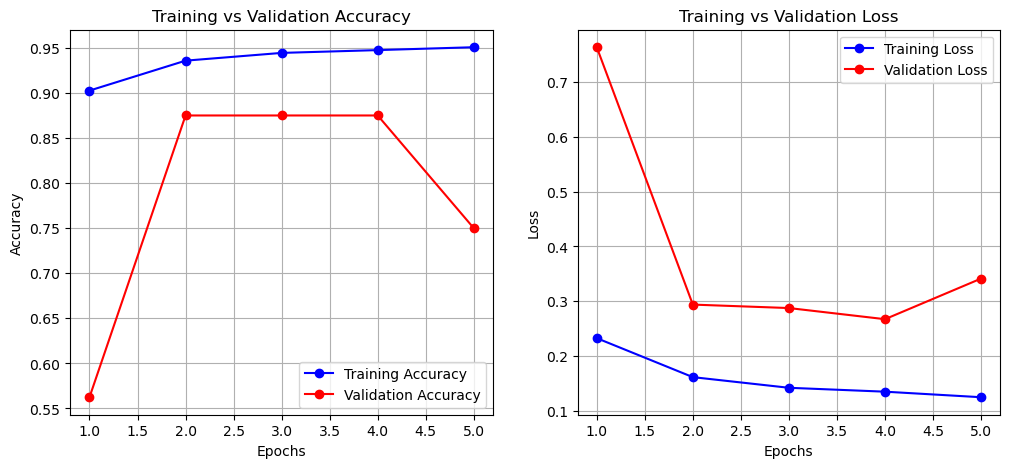

In [12]:
import matplotlib.pyplot as plt

# Training and validation accuracy
train_acc = [0.9026, 0.9358, 0.9444, 0.9475, 0.9507]
val_acc   = [0.5625, 0.8750, 0.8750, 0.8750, 0.7500]

# Training and validation loss
train_loss = [0.2328, 0.1618, 0.1424, 0.1353, 0.1252]
val_loss   = [0.7630, 0.2940, 0.2877, 0.2674, 0.3414]

epochs = range(1, 6)

# Plot Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [1]:
import os
print(os.getcwd())


C:\Users\Dell\Music\INTERNSHIP


In [8]:
import zipfile
import os

zip_path = r"C:\Users\Dell\Music\INTERNSHIP\X-ray_dataset.zip"
extract_to = r"C:\Users\Dell\Music\INTERNSHIP\images"  # or any folder you like

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction completed!")
print("Contents of images folder:", os.listdir(extract_to))


Extraction completed!
Contents of images folder: ['chest_xray']


In [9]:
import os

base_dir = r"C:\Users\Dell\Music\INTERNSHIP\images\chest_xray"
print("Contents of chest_xray folder:", os.listdir(base_dir))


Contents of chest_xray folder: ['test', 'train', 'val']


In [10]:
train_dir = r"C:\Users\Dell\Music\INTERNSHIP\images\chest_xray\train"
val_dir = r"C:\Users\Dell\Music\INTERNSHIP\images\chest_xray\val"
test_dir = r"C:\Users\Dell\Music\INTERNSHIP\images\chest_xray\test"


In [11]:
print("Train folder contents:", os.listdir(train_dir))  # Should show: ['NORMAL', 'PNEUMONIA'] or similar
print("Validation folder contents:", os.listdir(val_dir))
print("Test folder contents:", os.listdir(test_dir))


Train folder contents: ['NORMAL', 'PNEUMONIA']
Validation folder contents: ['NORMAL', 'PNEUMONIA']
Test folder contents: ['NORMAL', 'PNEUMONIA']


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, MobileNetV2, DenseNet121, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# ---  Set dataset paths ---
base_dir = r"C:\Users\Dell\Music\INTERNSHIP\images\chest_xray"

train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

In [4]:
# --- Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='binary')
val_gen   = val_datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='binary')
test_gen  = test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# --- EarlyStopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [6]:
# ---  Define Custom CNN ---
def create_custom_cnn(input_shape=(224,224,3)):
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
# ---  Define Transfer Learning Models ---
def create_transfer_model(base_model_class, input_shape=(224,224,3), units=256):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {
    "CustomCNN": create_custom_cnn(),
    "VGG16": create_transfer_model(VGG16),
    "VGG19": create_transfer_model(VGG19),
    "ResNet50": create_transfer_model(ResNet50),
    "MobileNetV2": create_transfer_model(MobileNetV2, units=128),
    "DenseNet121": create_transfer_model(DenseNet121),
    "EfficientNetB0": create_transfer_model(EfficientNetB0)
}


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# ---  Train and evaluate each model ---
results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=2,
        callbacks=[early_stop]
    )
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"{name} Test Accuracy: {test_acc:.4f}")
    results[name] = test_acc


--- Training CustomCNN ---
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 966s 6s/step - accuracy: 0.8393 - loss: 1.2670 - val_accuracy: 0.5000 - val_loss: 64.8706
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 1429s 9s/step - accuracy: 0.8857 - loss: 0.2957 - val_accuracy: 0.5000 - val_loss: 41.7756
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6250 - loss: 30.7442     
CustomCNN Test Accuracy: 0.6250

--- Training VGG16 ---
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 2010s 12s/step - accuracy: 0.8530 - loss: 0.3318 - val_accuracy: 0.7500 - val_loss: 0.5902
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 2055s 13s/step - accuracy: 0.9084 - loss: 0.2212 - val_accuracy: 0.8125 - val_loss: 0.3539
20/20 ━━━━━━━━━━━━━━━━━━━━ 240s 12s/step - accuracy: 0.8590 - loss: 0.3249
VGG16 Test Accuracy: 0.8590

--- Training VGG19 ---
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 2789s 17s/step - accuracy: 0.8307 - loss: 0.3692 - val_accuracy: 0.7500 - val_loss: 0.5998
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 2434s 15s/step - accur

In [9]:
# ---  Summary ---
print("\n=== Model Performance Summary ===")
for name, acc in results.items():
    print(f"{name}: Test Accuracy = {acc:.4f}")


=== Model Performance Summary ===
CustomCNN: Test Accuracy = 0.6250
VGG16: Test Accuracy = 0.8590
VGG19: Test Accuracy = 0.7660
ResNet50: Test Accuracy = 0.6250
MobileNetV2: Test Accuracy = 0.8846
DenseNet121: Test Accuracy = 0.8782
EfficientNetB0: Test Accuracy = 0.6250



========== CustomCNN ==========
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step   


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\s

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       234
           1     0.6250    1.0000    0.7692       390

    accuracy                         0.6250       624
   macro avg     0.3125    0.5000    0.3846       624
weighted avg     0.3906    0.6250    0.4808       624



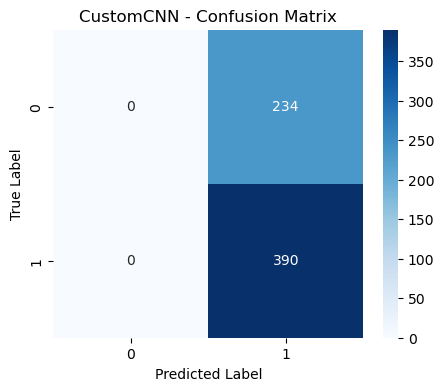


========== VGG16 ==========
20/20 ━━━━━━━━━━━━━━━━━━━━ 257s 12s/step
              precision    recall  f1-score   support

           0     0.7724    0.8846    0.8247       234
           1     0.9242    0.8436    0.8820       390

    accuracy                         0.8590       624
   macro avg     0.8483    0.8641    0.8534       624
weighted avg     0.8672    0.8590    0.8605       624



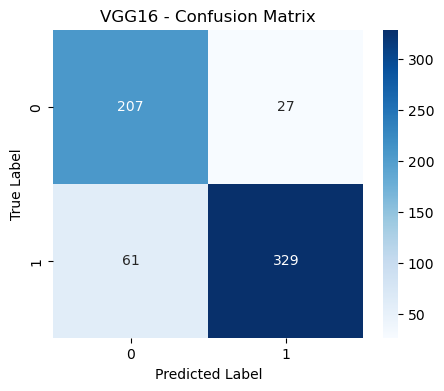


========== VGG19 ==========
20/20 ━━━━━━━━━━━━━━━━━━━━ 305s 15s/step
              precision    recall  f1-score   support

           0     0.8438    0.4615    0.5967       234
           1     0.7460    0.9487    0.8352       390

    accuracy                         0.7660       624
   macro avg     0.7949    0.7051    0.7159       624
weighted avg     0.7826    0.7660    0.7458       624



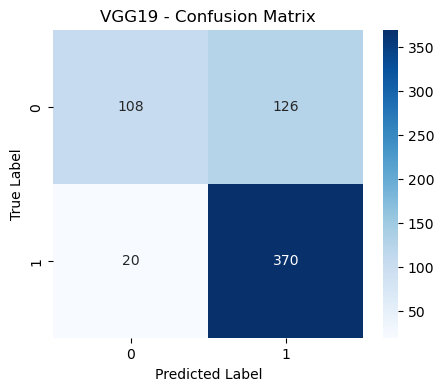


========== ResNet50 ==========
20/20 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       234
           1     0.6250    1.0000    0.7692       390

    accuracy                         0.6250       624
   macro avg     0.3125    0.5000    0.3846       624
weighted avg     0.3906    0.6250    0.4808       624



C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\s

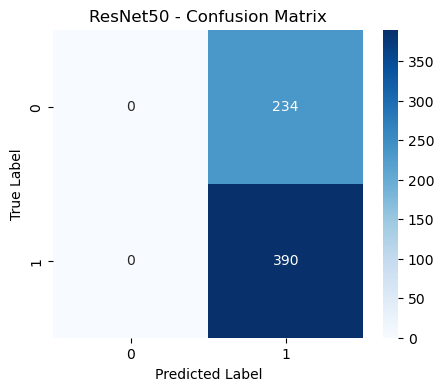


========== MobileNetV2 ==========
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step 
              precision    recall  f1-score   support

           0     0.9091    0.7692    0.8333       234
           1     0.8732    0.9538    0.9118       390

    accuracy                         0.8846       624
   macro avg     0.8912    0.8615    0.8725       624
weighted avg     0.8867    0.8846    0.8824       624



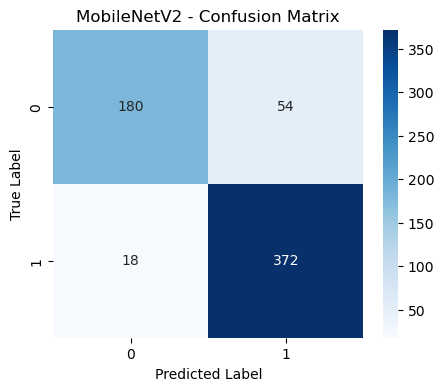


========== DenseNet121 ==========
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step 
              precision    recall  f1-score   support

           0     0.8211    0.8632    0.8417       234
           1     0.9153    0.8872    0.9010       390

    accuracy                         0.8782       624
   macro avg     0.8682    0.8752    0.8714       624
weighted avg     0.8800    0.8782    0.8788       624



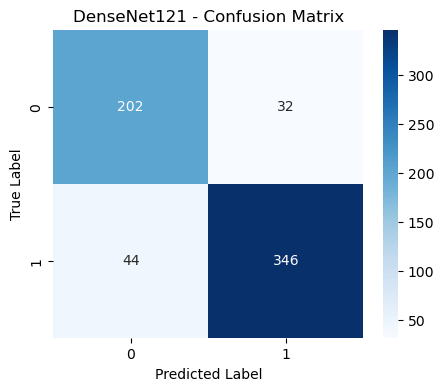


========== EfficientNetB0 ==========
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       234
           1     0.6250    1.0000    0.7692       390

    accuracy                         0.6250       624
   macro avg     0.3125    0.5000    0.3846       624
weighted avg     0.3906    0.6250    0.4808       624



C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\s

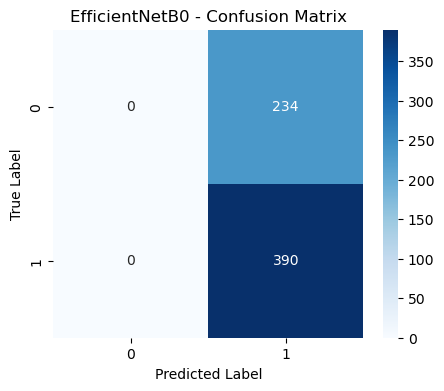

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

results = {}

# True labels from generator
y_true = test_gen.classes

for name, model in models.items():
    print(f"\n========== {name} ==========")

    # Get predictions
    y_pred_probs = model.predict(test_gen)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Classification report
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    results[name] = report

    print(classification_report(y_true, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


In [15]:
df_summary = pd.DataFrame([
    {
        "Model": name,
        "Precision (Pneumonia)": round(report["1"]["precision"], 4),
        "Recall / Sensitivity": round(report["1"]["recall"], 4),
        "F1 Score": round(report["1"]["f1-score"], 4),
        "Overall Accuracy": round(report["accuracy"], 4),
    }
    for name, report in results.items()
])

df_summary


,Model,Precision (Pneumonia),Recall / Sensitivity,F1 Score,Overall Accuracy
0,CustomCNN,0.6250,1.0000,0.7692,0.6250
1,VGG16,0.9242,0.8436,0.8820,0.8590
2,VGG19,0.7460,0.9487,0.8352,0.7660
3,ResNet50,0.6250,1.0000,0.7692,0.6250
4,MobileNetV2,0.8732,0.9538,0.9118,0.8846
5,DenseNet121,0.9153,0.8872,0.9010,0.8782
6,EfficientNetB0,0.6250,1.0000,0.7692,0.6250


In [16]:
df_summary.to_csv("Model_Performance_Summary.csv", index=False)
print("Saved as Model_Performance_Summary.csv")


Saved as Model_Performance_Summary.csv


In [17]:
# 1. Build/refresh results dict and summary DF
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Helper converting model outputs -> predicted labels robustly
def probs_to_labels(y_probs):
    """
    Accepts numpy array y_probs from model.predict:
    - if shape (N, ) or (N,1): treat as binary prob for class 1 -> threshold 0.5
    - if shape (N,2+) : take argmax for class label
    Returns labels shape (N,)
    """
    y_probs = np.asarray(y_probs)
    if y_probs.ndim == 1:
        return (y_probs > 0.5).astype(int)
    if y_probs.ndim == 2 and y_probs.shape[1] == 1:
        return (y_probs.ravel() > 0.5).astype(int)
    # multiclass/softmax
    if y_probs.ndim == 2 and y_probs.shape[1] > 1:
        return np.argmax(y_probs, axis=1)
    # fallback
    return (y_probs.ravel() > 0.5).astype(int)

# Ensure test true labels are available
y_true = test_gen.classes  # DirectoryIterator stores ground truth in .classes

results = {}  # will store classification_report output_dict for each model

for name, model in models.items():
    print("Processing:", name)
    y_probs = model.predict(test_gen, verbose=0)
    y_pred = probs_to_labels(y_probs)
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    results[name] = report

# Create DataFrame summary with metrics for class 1 (Pneumonia) and accuracy
rows = []
for name, rep in results.items():
    rows.append({
        "Model": name,
        "Precision_Class1": rep["1"]["precision"],
        "Recall_Class1": rep["1"]["recall"],
        "F1_Class1": rep["1"]["f1-score"],
        "Accuracy": rep["accuracy"]
    })

df_summary = pd.DataFrame(rows).sort_values("Recall_Class1", ascending=False).reset_index(drop=True)
df_summary


Processing: CustomCNN


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing: VGG16
Processing: VGG19
Processing: ResNet50


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing: MobileNetV2
Processing: DenseNet121
Processing: EfficientNetB0


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Precision_Class1,Recall_Class1,F1_Class1,Accuracy
0,CustomCNN,0.625000,1.000000,0.769231,0.625000
1,EfficientNetB0,0.625000,1.000000,0.769231,0.625000
2,ResNet50,0.625000,1.000000,0.769231,0.625000
3,MobileNetV2,0.873239,0.953846,0.911765,0.884615
4,VGG19,0.745968,0.948718,0.835214,0.766026
5,DenseNet121,0.915344,0.887179,0.901042,0.878205
6,VGG16,0.924157,0.843590,0.882038,0.858974


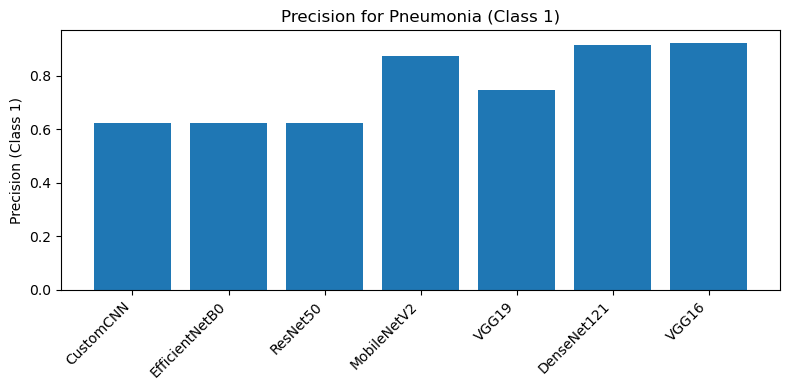

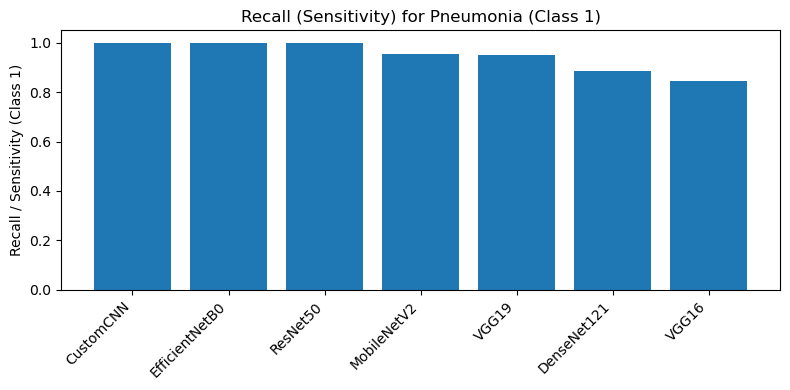

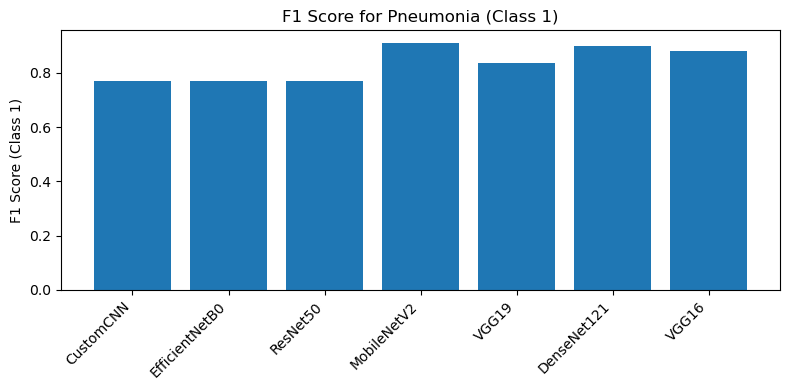

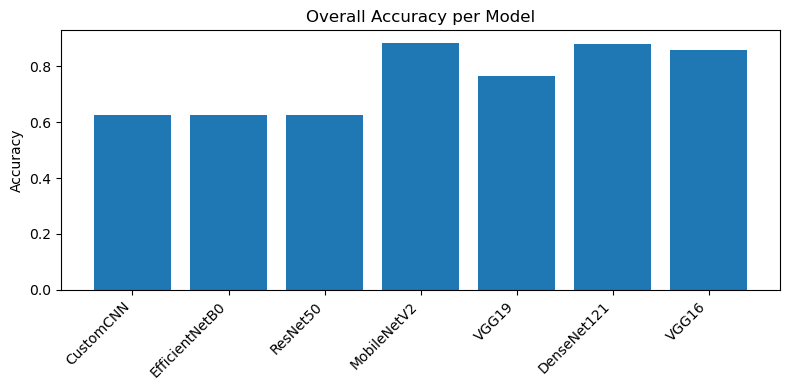

In [18]:
import matplotlib.pyplot as plt

# x labels & values
labels = df_summary["Model"].tolist()
x = range(len(labels))

# Precision (Class1)
plt.figure(figsize=(8,4))
plt.bar(x, df_summary["Precision_Class1"])
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Precision (Class 1)")
plt.title("Precision for Pneumonia (Class 1)")
plt.tight_layout()
plt.show()

# Recall (Class1)
plt.figure(figsize=(8,4))
plt.bar(x, df_summary["Recall_Class1"])
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Recall / Sensitivity (Class 1)")
plt.title("Recall (Sensitivity) for Pneumonia (Class 1)")
plt.tight_layout()
plt.show()

# F1 (Class1)
plt.figure(figsize=(8,4))
plt.bar(x, df_summary["F1_Class1"])
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("F1 Score (Class 1)")
plt.title("F1 Score for Pneumonia (Class 1)")
plt.tight_layout()
plt.show()

# Overall Accuracy
plt.figure(figsize=(8,4))
plt.bar(x, df_summary["Accuracy"])
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Overall Accuracy per Model")
plt.tight_layout()
plt.show()


In [19]:
df_summary.to_csv("model_performance_summary.csv", index=False)
print("Saved: model_performance_summary.csv")


Saved: model_performance_summary.csv


In [20]:

# Pick best model by highest recall for pneumonia (class 1)
best_row = df_summary.iloc[df_summary["Recall_Class1"].idxmax()]
best_model_name = best_row["Model"]
best_recall = best_row["Recall_Class1"]

print(f"Best model by Recall (Class1): {best_model_name}  (Recall={best_recall:.4f})")

best_model = models[best_model_name]


Best model by Recall (Class1): CustomCNN  (Recall=1.0000)


In [26]:
model_scores = {
    "CustomCNN": 0.6250,
    "VGG16": 0.8590,
    "VGG19": 0.7660,
    "ResNet50": 0.6250,
    "MobileNetV2": 0.8846,
    "DenseNet121": 0.8782,
    "EfficientNetB0": 0.6250
}


In [27]:
best_model_name = max(model_scores, key=model_scores.get)
print("Best Model:", best_model_name)


Best Model: MobileNetV2


In [28]:
best_model = models[best_model_name]


In [30]:
# Save in .keras format
best_model.save(f"{best_model_name}.keras")
print(f"Saved as {best_model_name}.keras")

# Save in .h5 format
best_model.save(f"{best_model_name}.h5")
print(f"Saved as {best_model_name}.h5")

# Save TensorFlow SavedModel (Keras 3 syntax)
saved_folder = f"{best_model_name}_saved_model"
best_model.export(saved_folder)
print(f"Saved TensorFlow SavedModel folder: {saved_folder}")


Saved as MobileNetV2.keras
Saved as MobileNetV2.h5
INFO:tensorflow:Assets written to: MobileNetV2_saved_model\assets


INFO:tensorflow:Assets written to: MobileNetV2_saved_model\assets


Saved artifact at 'MobileNetV2_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_320')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2179587701072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2179587701840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2179587701648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2179587702032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2179587700496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2179587701264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2179587702416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2179587702224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2179587701456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2179587702608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2179587699728: TensorSp

In [31]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


In [32]:
model = tf.keras.models.load_model("MobileNetV2.keras")
print("Model Loaded Successfully!")


Model Loaded Successfully!


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [41]:
pip install gradio


Note: you may need to restart the kernel to use updated packages.


In [43]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np


In [44]:
best_model = tf.keras.models.load_model("MobileNetV2.keras")


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [45]:
def predict_xray(img):
    # Resize to model input size
    img = img.resize((224, 224))
    
    # Convert to array
    img_array = image.img_to_array(img)
    
    # Scale
    img_array = img_array / 255.0
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    pred = best_model.predict(img_array)[0][0]
    
    # Set threshold (0.5 for binary)
    if pred > 0.5:
        label = "Pneumonia"
    else:
        label = "Healthy"
    
    # Confidence
    confidence = float(pred if label=="Pneumonia" else 1-pred)
    
    return {label: confidence, "Healthy" if label=="Pneumonia" else "Pneumonia": 1-confidence}


In [46]:
iface = gr.Interface(
    fn=predict_xray,           # function to call
    inputs=gr.Image(type="pil"),  # upload image
    outputs=gr.Label(num_top_classes=2),  # show top 2 predictions
    title="Chest X-ray Classifier",
    description="Upload a chest X-ray image. Model predicts Healthy vs Pneumonia."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [47]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


In [50]:
import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Load model
model = tf.keras.models.load_model("MobileNetV2.keras")

st.title("Chest X-ray Classifier")
st.write("Upload a chest X-ray image to classify as Healthy or Pneumonia")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg","png"])
if uploaded_file is not None:
    img = Image.open(uploaded_file)
    st.image(img, caption='Uploaded X-ray', use_column_width=True)
    
    # Preprocess
    img_resized = img.resize((224,224))
    img_array = image.img_to_array(img_resized)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    pred = model.predict(img_array)[0][0]
    label = "Pneumonia" if pred > 0.5 else "Healthy"
    confidence = pred if label=="Pneumonia" else 1-pred
    
    st.write(f"Prediction: {label}")
    st.write(f"Confidence: {confidence:.2f}")


2025-11-30 09:56:10.647 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 09:56:10.648 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 09:56:10.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 09:56:10.651 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 09:56:10.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 09:56:10.657 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 09:56:10.661 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 09:56:10.665 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [52]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

model = tf.keras.models.load_model("MobileNetV2.keras")

def predict_xray(img):
    img_resized = img.resize((224,224))
    img_array = image.img_to_array(img_resized)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]
    label = "Pneumonia" if pred > 0.5 else "Healthy"
    confidence = pred if label=="Pneumonia" else 1-pred
    return f"{label} ({confidence:.2f})"

gr.Interface(fn=predict_xray, inputs=gr.Image(type="pil"), outputs="text", title="Chest X-ray Classifier").launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [54]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load your trained model
model = tf.keras.models.load_model("MobileNetV2.keras")

# Define prediction function
def predict_xray(img):
    img = img.resize((224, 224))              # Resize image
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred_prob = model.predict(img_array)[0][0]
    if pred_prob > 0.5:
        label = "Pneumonia"
        confidence = pred_prob
    else:
        label = "Healthy"
        confidence = 1 - pred_prob
    
    return {label: float(confidence)}

# Create Gradio interface
interface = gr.Interface(
    fn=predict_xray,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="Chest X-ray Pneumonia Classifier",
    description="Upload a chest X-ray image to detect Pneumonia vs Healthy"
)

# Launch the app
interface.launch(share=True)


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://f15a1a8ae70985e10d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
